# Time series forecasting for customers in a shop

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Problem to understand 

predict future customers in shop (Data is from 1949 to 1960)

In [6]:
data = pd.read_csv('customer_in_shop.csv')
data.columns = ['Date','Customers']
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m')
data = data.set_index('Date')

In [8]:
data.shape

(143, 1)

In [10]:
data.head(10)

,Customers
Date,
1949-02-01,120.0
1949-03-01,134.0
1949-04-01,67.0
1949-05-01,123.0
1949-06-01,137.0
1949-07-01,150.0
1949-08-01,50.0
1949-09-01,138.0
1949-10-01,121.0


In [11]:
data.tail()

,Customers
Date,
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,720.0
1960-11-01,750.0
1960-12-01,732.0


## Data Preprocessing

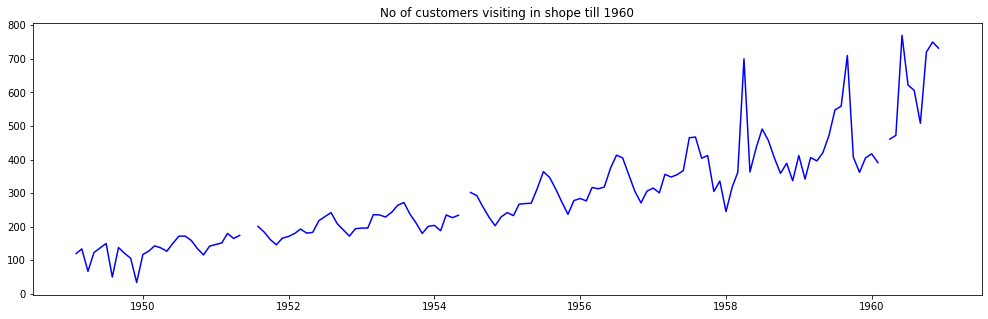

In [17]:
plt.rcParams['figure.figsize'] = (17,5)
plt.plot(data,color='blue')
plt.title('No of customers visiting in shope till 1960')
plt.show()

### Options for imputing missing values <br />
1. Mean imputation => taking mean <br />
2. Last Observation Carried Forward => taking last value <br />
3. Linear interpolation => straight line joining previous and next points of missing value <br />
4. Seasonal interpolation

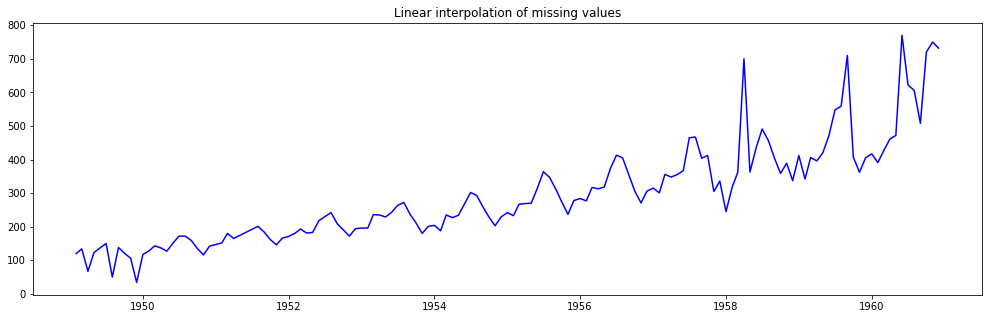

In [18]:
plt.rcParams['figure.figsize'] = (17,5)
data['Customers_linear'] = data['Customers'].interpolate(method='linear')
plt.plot(data['Customers_linear'],color='blue')
plt.title('Linear interpolation of missing values')
plt.show()

In [19]:
data['Customers'] = data['Customers_linear']

### Detecting outliers

Boxplot => value less than q1-1.5*IQR or greater than Q3+1.5*IQR = outlier

<AxesSubplot:xlabel='Customers_linear'>

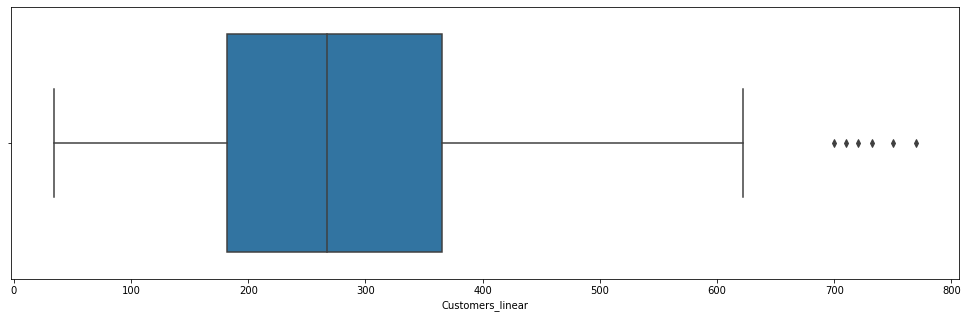

In [20]:
sns.boxplot(data['Customers_linear'])

In [21]:
data['Customers_linear'].loc[(data['Customers_linear'] >= 700)] = 622

data.isnull().sum()

Customers           0
Customers_linear    0
dtype: int64

<AxesSubplot:xlabel='Customers_linear'>

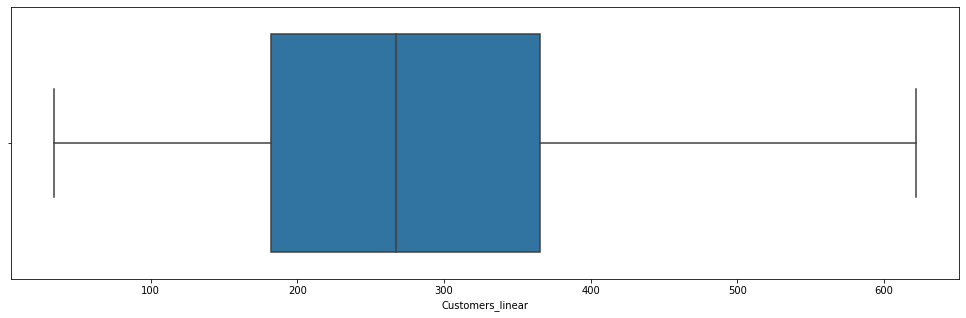

In [22]:
sns.boxplot(data['Customers_linear'])

### Components of time series
1. Level
2. Trend
3. Seasonality

## Time series decomposition

In [28]:
import statsmodels.api as sm

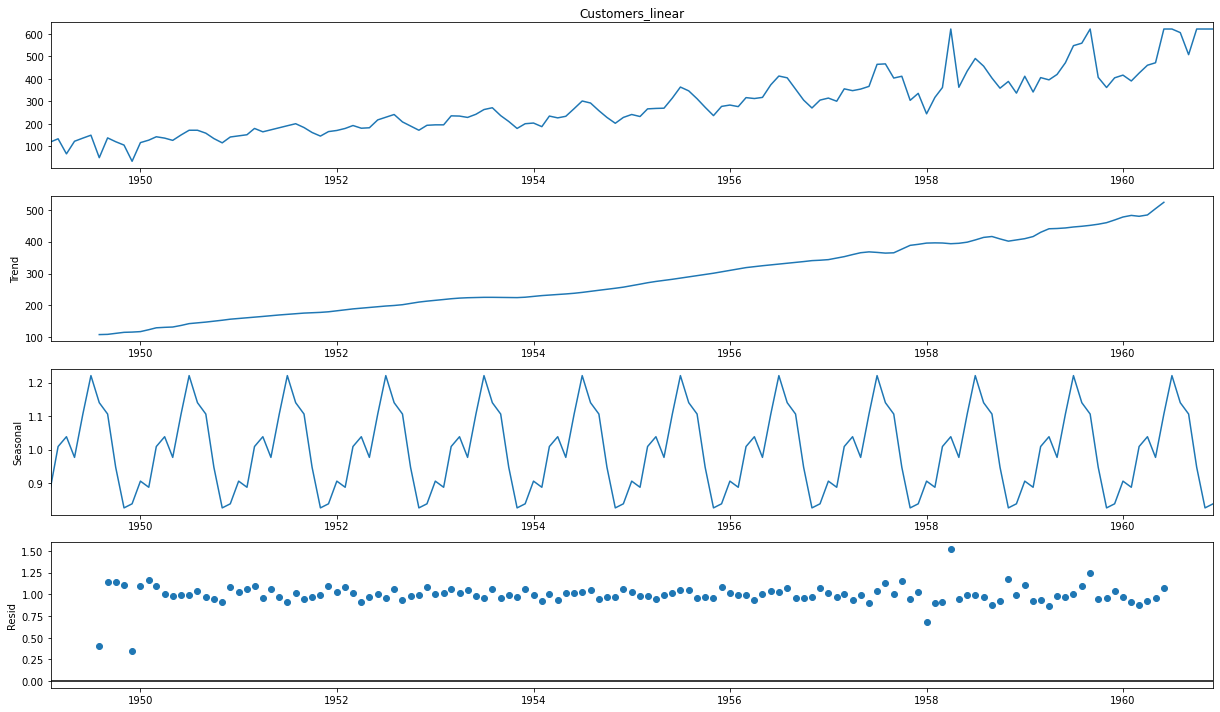

In [31]:
plt.rcParams['figure.figsize'] = (17,10)
decomposition = sm.tsa.seasonal_decompose(data['Customers_linear'], model='multiplicative')
fig = decomposition.plot()
plt.show()

## Modelling

In [32]:
train_length = 115
train = data.iloc[:train_length,:]
test = data.iloc[train_length:,:]

In [33]:
train.shape

(115, 2)

In [34]:
train.tail()

,Customers,Customers_linear
Date,,
1958-04-01,700.0,622.0
1958-05-01,363.0,363.0
1958-06-01,435.0,435.0
1958-07-01,491.0,491.0
1958-08-01,457.0,457.0


In [35]:
test.shape

(28, 2)

In [36]:
test.tail()

,Customers,Customers_linear
Date,,
1960-08-01,606.0,606.0
1960-09-01,508.0,508.0
1960-10-01,720.0,622.0
1960-11-01,750.0,622.0
1960-12-01,732.0,622.0


### Holt's winter exponential equation
Formula is: y(t+1) = l(t) + b(t) + s(t+1-m)

In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train['Customers'],seasonal_periods = 12, trend = 'multiplicative', seasonal = 'additive')
model_fit = model.fit(smoothing_level = 0.2, smoothing_slope = 0.04)
model_fit.params

y_holtwinter = test.copy()
y_holtwinter['holtwinter_forecast'] = model_fit.forecast(36) #36 is months

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


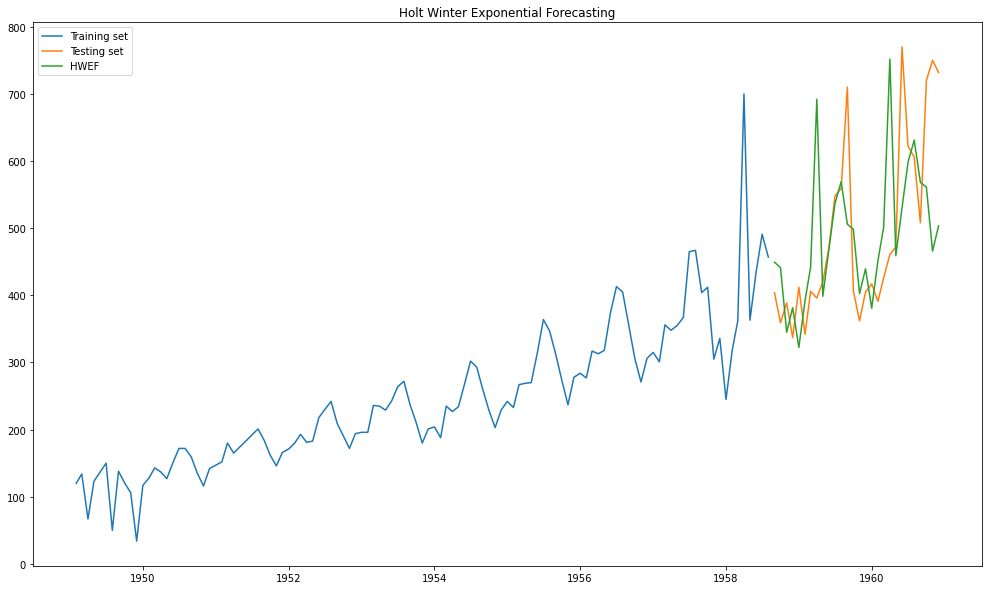

In [42]:
# plt.rcParams['figure.figsize'] = (17,5)
plt.plot(train['Customers'],label='Training set')
plt.plot(test['Customers'],label='Testing set')
plt.plot(y_holtwinter['holtwinter_forecast'],label='HWEF')

plt.title('Holt Winter Exponential Forecasting')
plt.legend()
plt.show()

## SARIMA Model <br />

Assumptions:
1. Stationarity = statistical properties doesnot change over time, eg mean, variance, covariance
2. Autocorrelation

In [44]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Customers_linear'], autolag="AIC")
print(f'ADF Stats: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')

for key,value in result[4].items():
    print('Critical Values: ')
    print(f'         {key}. {value}  ')


ADF Stats: 2.666641596688896
n_lags: 0.999084528049919
p-value: 0.999084528049919
Critical Values: 
         1%. -3.4825006939887997  
Critical Values: 
         5%. -2.884397984161377  
Critical Values: 
         10%. -2.578960197753906  


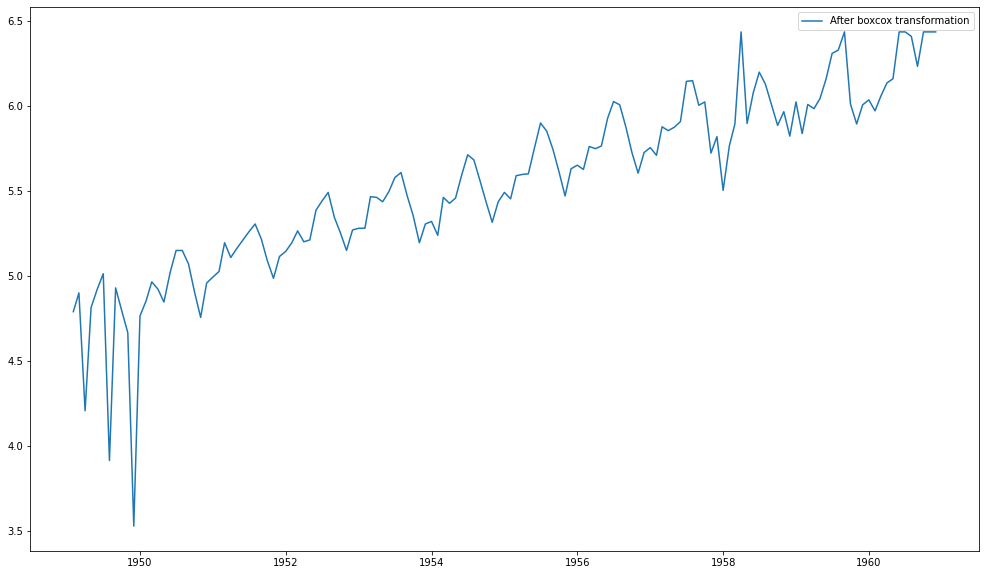

In [47]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Customers_linear'],lmbda = 0),index = data.index)

plt.plot(data_boxcox, label = "After boxcox transformation")
plt.legend(loc='best')
plt.show()

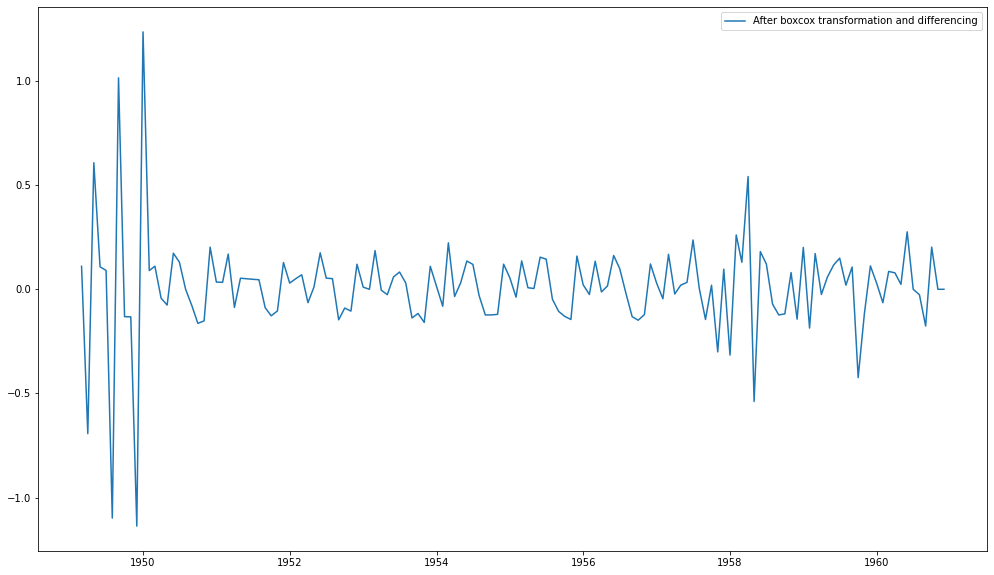

In [50]:
data_boxcox_difference = pd.Series(data_boxcox - data_boxcox.shift(),index = data.index)
data_boxcox_difference.dropna(inplace = True)

plt.plot(data_boxcox_difference, label = "After boxcox transformation and differencing")
plt.legend()
plt.show()

In [51]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_boxcox_difference, autolag="AIC")
print(f'ADF Stats: {result[0]}')
print(f'n_lags: {result[1]:.20f}')
print(f'p-value: {result[1]:.20f}')

for key,value in result[4].items():
    print('Critical Values: ')
    print(f'         {key}. {value}  ')


ADF Stats: -9.037677019419961
n_lags: 0.00000000000000523545
p-value: 0.00000000000000523545
Critical Values: 
         1%. -3.481281802271349  
Critical Values: 
         5%. -2.883867891664528  
Critical Values: 
         10%. -2.5786771965503177  


## Autocorrelation

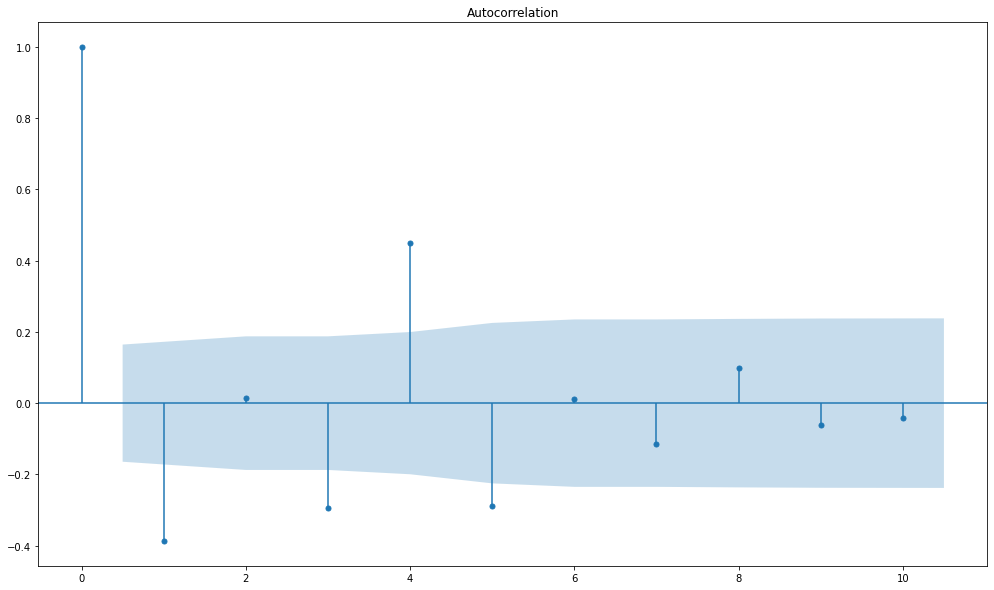

In [53]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_boxcox_difference, ax = plt.gca(), lags = 10)
plt.title('Autocorrelation')
plt.show()

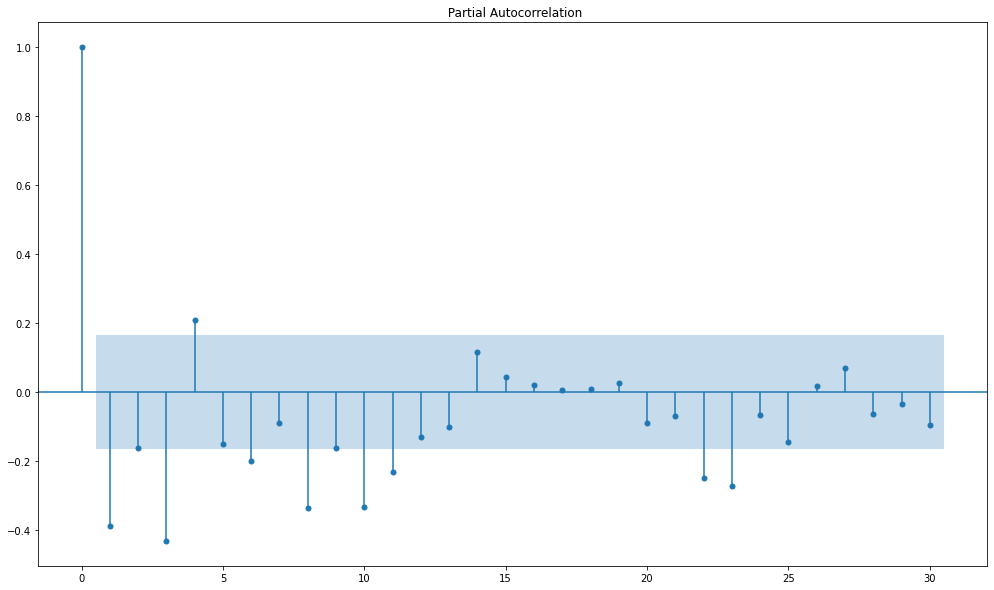

In [54]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data_boxcox_difference, ax = plt.gca(), lags = 30)
plt.title(' Partial Autocorrelation')
plt.show()

## Applying SARIMA MODEL

In [56]:
train_data_boxcox_ = data_boxcox[:train_length]
test_data_boxcox_ = data_boxcox[train_length:]

train_data_boxcox_difference = data_boxcox_difference[:train_length-1]
test_data_boxcox_difference = data_boxcox_difference[train_length-1:]

### key elements of sarima model <br />
1. Time series is differenced to make it stationary
2. SARIMA equation is a linear combination of past observations and past errors.
3. Seasonal differencing is performed on time series.
4. SARIMA models future seasonality as linear combination of past seasonality observations and past seasonality errors.
5. paramters include p,q,d,m,P,Q,D

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox_difference, order=(1,1,1), seasonal_order = (1,1,1,6))
model_fit = model.fit()
print(model_fit.params)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar.L1     -0.575857
ma.L1     -0.997792
ar.S.L6   -0.738167
ma.S.L6   -0.552266
sigma2     0.049462
dtype: float64


## Recover Time Series Data

In [ ]:
y_sarima_new = test_data_boxcox_difference.copy()
y_sarima_new['sarima_forecast_boxcox_difference'] = model_fit.predict(test_data_boxcox_difference.index.min(), test_data_boxcox_difference.index.max())
